## Figure 6
Results from a parcel simulation with Na = 200 cm-3, Forg = 0.5, and w = 0.5 m/s.
Difference in CDNC profiles between the different surface-partitioning models and constant surface tension.
Solid lines show best fit parameter values, while shading indicates the variability from changing the parameter values within 1std.

Comparing the structural vs. parametric uncertainty. Are shadings wider than difference between curves?

In [8]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open_atmos_jupyter_utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [9]:
import numpy as np
from joblib import Parallel, delayed
import pickle as pkl

from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.initialisation.spectra import Sum

from PySDM_examples.Singer_Ward import Settings, ParcelSimulation
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark
from PySDM_examples.Singer_Ward.constants_def import SINGER_CONSTS, plot_colors, plot_lines, plot_names

In [10]:
save = True
restore_saved_data = False

FORMULAE = Formulae(constants=SINGER_CONSTS)
# WATER_MOLAR_VOLUME = FORMULAE.constants.water_molar_volume
WATER_MOLAR_VOLUME = FORMULAE.constants.Mv / FORMULAE.constants.rho_w

models = ('Constant', 'CompressedFilmOvadnevaite', 'SzyszkowskiLangmuir', 'CompressedFilmRuehl')
aerosol = AerosolBetaCaryophylleneDark(water_molar_volume=WATER_MOLAR_VOLUME, Forg=0.5, N=200)
samples = range(2)

In [11]:
def genkey(model, sample):
    return f"{model}-{sample}"

if restore_saved_data:
    with open('data_fig6.pkl','rb') as file:
        output = pkl.load(file)
else:
    def compute(key, settings):
        simulation = ParcelSimulation(settings)
        output = simulation.run()
        model = key.split("-")[0]
        output['color'] = plot_colors[model]
        output['linestyle'] = plot_lines[model]
        output['Na_tot'] = Sum(
            tuple(settings.aerosol.modes[i]['spectrum']
                    for i in range(len(settings.aerosol.modes)))).norm_factor
        return key, output

    print(f'tasks scheduled: {len(models) * len(samples)}')
    output = dict(Parallel(verbose=10, n_jobs=-1)(
        delayed(compute)(genkey(model, sample), Settings(
            dz = 1 * si.m, 
            n_sd_per_mode = 100, 
            model = model,
            aerosol = aerosol,
            w = 0.5 * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
        ))
        for model in models
        for sample in samples
    ))

    if save:
        with open('data_fig6.pkl','wb') as file:
            pkl.dump(output, file)

tasks scheduled: 8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   31.6s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   37.8s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   38.8s remaining:   38.8s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   48.4s remaining:   29.1s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   49.4s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   57.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   57.7s finished


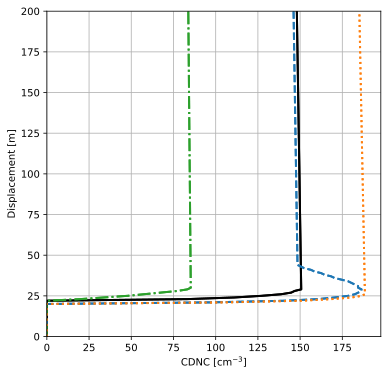

HTML(value="<a href='./fig6.pdf' target='_blank'>./fig6.pdf</a><br>")

In [14]:
fig, axes = pyplot.subplots(1, 1, figsize=(6,6))

var = "CDNC"
ax = axes
for key, output_k in output.items():
    model = key.split("-")[0]
    Y = np.asarray(output_k['z'])
    ax.plot(output_k[var], Y, 
            label=plot_names[model], 
            color=output_k['color'],
            linestyle=output_k['linestyle'],
            lw=2,
            )
ax.set_ylim(0, 200)
ax.set_ylabel('Displacement [m]')
ax.set_xlim(0)
ax.set_xlabel('CDNC [cm$^{-3}$]')
ax.grid()

show_plot("fig6.pdf")